In [1]:
from datasets import load_dataset

dataset = load_dataset("banking77")

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [4]:
%%capture
!pip install nltk
!pip install contractions
!pip install Unidecode
!pip install textblob
!pip install pyspellchecker

In [262]:
import contractions
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from textblob import TextBlob
from unidecode import unidecode


class EnglishPipeline():
    
    def __init__(self,
                 uncased=False,
                 lemmatized=False,
                 stemmed=False,
                 remove_stopwords=False,
                 remove_contractions=False,
                 remove_numbers=False,
                 remove_punctuation=False,
                 fix_spelling=False
                ):
    
        self.uncased = uncased
        self.lemmatized = lemmatized
        self.stemmed = stemmed
        self.remove_stopwords = remove_stopwords
        self.remove_contractions = remove_contractions
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.fix_spelling = fix_spelling

        if self.remove_stopwords:
            nltk.download("stopwords")
            self.stopwords = stopwords.words('english')
        if self.stemmed:
            if self.lemmatized:
                self.lemmatized = False
            self.stemmer = SnowballStemmer("english")
        if self.lemmatized:
            self.nlp = spacy.load("en_core_web_sm")
    
    def transform(self, string):
        
        if self.uncased:
            string = string.lower()
            
        # remove diacritics
        string = unidecode(string, errors="preserve")
            
        if self.remove_contractions:
            string = " ".join([contractions.fix(expanded) for expanded in string.split()])
            
        if self.remove_numbers:
            string = re.sub(r'\d+', '', string)
            
        if self.fix_spelling:
            string = str(TextBlob(string).correct())
            
        if self.remove_punctuation:
            string = " ".join(x for x in word_tokenize(string) if x not in punctuation)
            
        if self.lemmatized:
            string = " ".join(x.lemma_ for x in self.nlp(string))
        elif self.stemmed:
            string = self.stemmer.stem(string) 
            
        if self.remove_stopwords:
            string = " ".join([word for word in string.split() if word not in self.stopwords])
            
        # remove trailing spaces
        string = re.sub(' +', ' ', string)
        
        return string

In [268]:
nltk.download("stopwords")
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Сначала просто список фичей, которые я генерю, можно не делать, просто загрузить датасет чуть ниже

In [269]:
pipeline = EnglishPipeline(lemmatized=True,
                           remove_contractions=True,
                           remove_numbers=True,
                           fix_spelling=True,
                           remove_punctuation=True)

X_train["lemmas"] = X_train["text"].progress_apply(lambda x: pipeline.transform(x))
X_test["lemmas"] = X_test["text"].progress_apply(lambda x: pipeline.transform(x))
X_train["punct_count"] = X_train.text.apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
X_test["punct_count"] = X_test.text.apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
X_train['sw_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stopwords]))
X_test['sw_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stopwords]))
X_train['cased_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
X_test['cased_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
X_train["sent_len"] = X_train.text.apply(lambda x: len(x.split()))
X_test["sent_len"] = X_test.text.apply(lambda x: len(x.split()))
X_train["char_count"] = X_train.text.apply(len)
X_test["char_count"] = X_test.text.apply(len)
X_train["text_density"] = X_train['char_count'] / (X_train['sent_len']+1)
X_test["text_density"] = X_test['char_count'] / (X_test['sent_len']+1)
X_train['polarity'] = X_train['text'].apply(get_polarity)
X_test['polarity'] = X_test['text'].apply(get_polarity)

with open("/kaggle/input/some-stuff/intent_mapper.txt", "r") as f:
    intent_mapper = {int(x.split()[0]): x.split()[1] for x in f.readlines()}
    
y_train = pd.DataFrame(dataset["train"]["label"], columns=["label"]).map(intent_mapper)
y_test = pd.DataFrame(dataset["test"]["label"], columns=["label"]).map(intent_mapper)

In [4]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                  stratify=y_train, random_state=666)

У катбуста всё замечательно с текстами, но если хочется - можно посмотреть на tfidf, может быть, что-то получится с ним

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = ['sent_len', 'punct_count', 'char_count',
            'text_density', 'sw_count', 'cased_count', 'polarity', 'PRON', 'VERB',
            'ADV', 'ADP', 'NOUN', 'ADJ', 'DET', 'CONJ', 'PRT', 'NUM', '.', 'X']
text_cols = "text"

preprocess = ColumnTransformer(
    [
        ("scaling", StandardScaler(), num_cols),
        ("tfidf", TfidfVectorizer(ngram_range=(1, 5), analyzer="char"), text_cols)
    ])

In [319]:
train = preprocess.fit_transform(X_train)
val = preprocess.transform(X_val)

In [ ]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(text_features=["lemmas"], early_stopping_rounds=10)
cbc.fit(X_train.drop(["text"], axis=1), y_train,
        eval_set=(X_val.drop(["text"], axis=1), y_val))

In [28]:
y_pred = cbc.predict(X_test.drop(["text"], axis=1))

In [13]:
from sklearn.metrics import accuracy_score, f1_score

f1_score(y_pred, y_test.values, average="micro")

0.8665584415584415

Без предобработки было около 0.82

<AxesSubplot:>

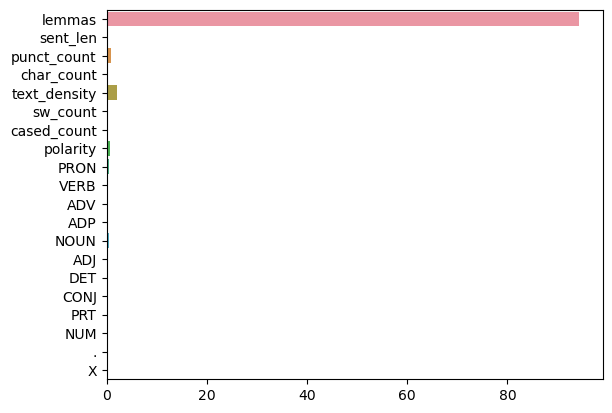

In [20]:
sns.barplot(y=cbc.feature_names_, x=cbc.feature_importances_)

In [15]:
cbc.save_model("catboost_lemmas")

Гиперпараметры пока не оптимизировал, непонятно, надо ли оно нам

In [ ]:
def objective(trial: optuna.Trial) -> float:
    data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy